<a href="https://colab.research.google.com/github/rushirajsherlocked/FastAi-Projects/blob/master/FastAi_3%2C_Image_Segmentation_(Camvid).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation with Camvid

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

# Subset Classes

In [0]:
# NOTE: The below cell can be used just for person segmentation (my use case)

In [0]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

# Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3] 

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00000.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_00960.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06540.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]                                  

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_01770_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_009930_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f02280_P.png')]

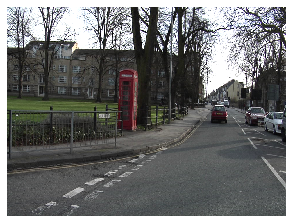

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

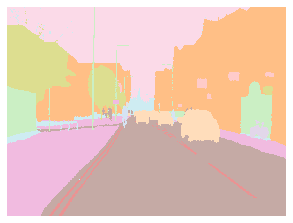

In [8]:
lbl_f = lbl_names[0]
label = open_mask(lbl_f)
label.show(figsize=(5,5)) # add alpha = 1 to see the changes

In [9]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}' 

In [11]:
img_f

PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00000.png')

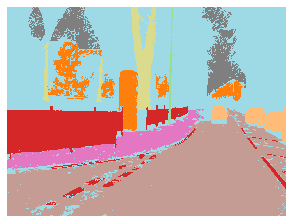

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
get_y_fn(img_f)    # See the Change in Name

PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f00000_P.png')

In [14]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[30, 30, 30,  ..., 29, 29, 29],
          [30, 30, 30,  ..., 29, 29, 29],
          [30, 30, 30,  ..., 29, 29, 29],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

# Datasets

In [15]:
size = src_size//2

free = gpu_mem_get_free_no_cache()

if free>8200: bs = 8
else : bs = 4

print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16270MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

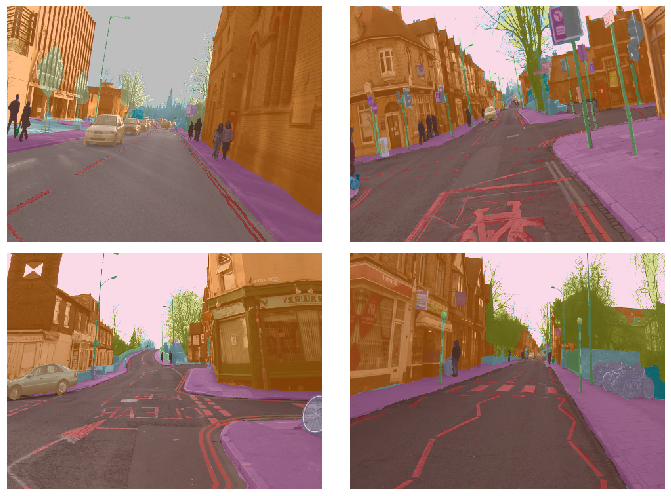

In [18]:
data.show_batch(2, figsize=(10,7))

# Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
wd=1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


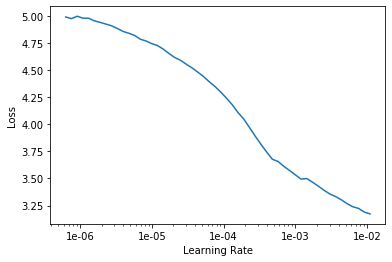

In [23]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-4

In [25]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,3.499449,2.627596,0.300632,00:55
1,1.961046,1.148074,0.741350,00:52
2,1.261695,0.902425,0.782000,00:52
3,0.955732,0.720213,0.823687,00:52
4,0.790523,0.644666,0.834964,00:51
5,0.689426,0.529236,0.854963,00:52
6,0.634535,0.578857,0.826967,00:52
7,0.574456,0.529749,0.856767,00:51
8,0.551352,0.466228,0.870527,00:52
9,0.489082,0.412034,0.875972,00:52


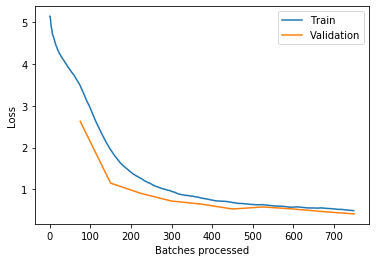

In [26]:
learn.recorder.plot_losses()

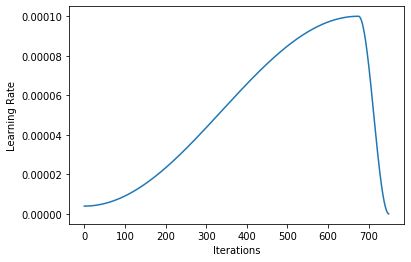

In [27]:
learn.recorder.plot_lr()

In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

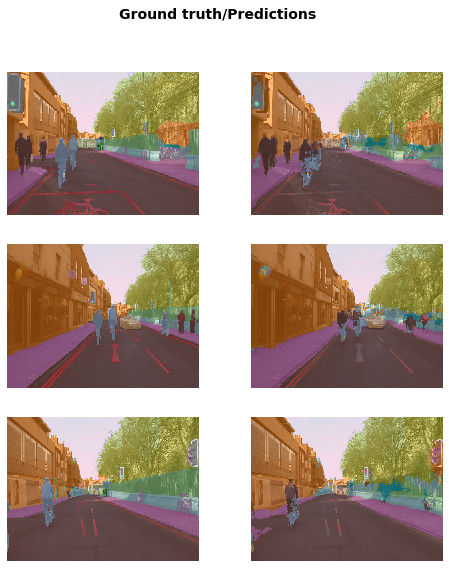

In [30]:
learn.show_results(rows=3,figsize=(8,9))

In [0]:
learn.unfreeze()

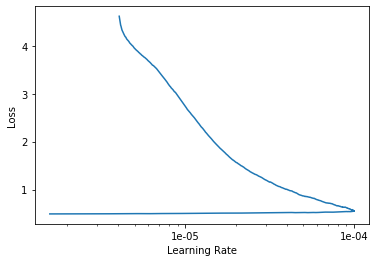

In [32]:
learn.recorder.plot()

In [0]:
lrs = slice(lr/400,lr/4)

In [34]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.433979,0.400434,0.880535,00:54
1,0.436049,0.398906,0.880797,00:53
2,0.434329,0.401587,0.881257,00:53
3,0.429902,0.396878,0.882919,00:53
4,0.429131,0.385951,0.885665,00:53
5,0.424954,0.386590,0.888483,00:53
6,0.414177,0.374572,0.891237,00:53
7,0.412702,0.360618,0.898322,00:53
8,0.397200,0.364857,0.893234,00:53
9,0.395689,0.355789,0.896815,00:54


In [0]:
learn.save('stage-2');

# Go Big

In [37]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 15559MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


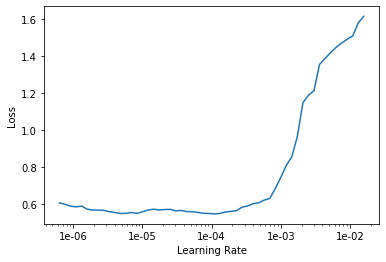

In [41]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-5

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-2-big');

In [0]:
learn.show_results(rows=3, figsize=(10,10))